11.344262899408


******** <class 'pyscf.pbc.dft.rks.RKS'> ********
method = RKS-RHF-SCF-RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-07
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = False
chkfile to save SCF result = /var/folders/n4/_rxx4pb146zbgdr275j17cb00000gn/T/tmpdtlq1iia
max_memory 4000 MB (current use 0 MB)
******** PBC SCF flags ********
kpt = [0. 0. 0.]
Exchange divergence treatment (exxdiv) = ewald
Ewald components = 3.05332332723449e-48, -1.2272855558014, 0.887176140494645
    madelung (= occupied orbital energy shift) = 0.6802188306135006
    Total energy shift due to Ewald probe charge = -1/2 * Nelec*madelung = -2.72087532245
DF object = <pyscf.pbc.df.fft.FFTDF object at 0x7fcfe246f910>


******** <class 'pyscf.pbc.df.fft.FFTDF'> ********
mesh = [29 29 29] (24389 PWs)
len(kpts) = 1
XC functionals = LDA,VWN
small_rho_cutoff = 1e-07
Uniform grid, me

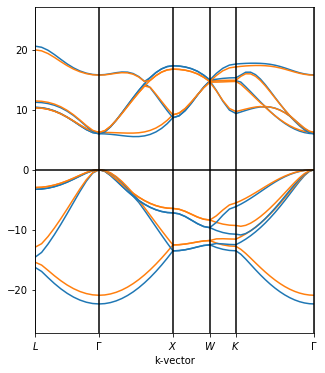

In [3]:
import pyscf.pbc.tools.pyscf_ase as pyscf_ase
import pyscf.pbc.gto as pbcgto
import pyscf.pbc.dft as pbcdft

import matplotlib.pyplot as plt

from ase.lattice import bulk
from ase.dft.kpoints import sc_special_points as special_points, get_bandpath

c = bulk('C', 'diamond', a=3.5668)
print(c.get_volume())

cell = pbcgto.Cell()
cell.atom = pyscf_ase.ase_atoms_to_pyscf(c)
cell.a = c.cell

cell.basis = 'gth-szv'
cell.pseudo = 'gth-pade'
cell.verbose = 5
cell.build(None,None)

points = special_points['fcc']
G = points['G']
X = points['X']
W = points['W']
K = points['K']
L = points['L']
band_kpts, kpath, sp_points = get_bandpath([L, G, X, W, K, G], c.cell, npoints=50)
band_kpts = cell.get_abs_kpts(band_kpts)

#
# band structure from Gamma point sampling
#

mf = pbcdft.RKS(cell)
print(mf.kernel())

e_kn = mf.get_bands(band_kpts)[0]
vbmax = -99
for en in e_kn:
    vb_k = en[cell.nelectron//2-1]
    if vb_k > vbmax:
        vbmax = vb_k
e_kn = [en - vbmax for en in e_kn]

#
# band structure from 222 k-point sampling
#

kmf = pbcdft.KRKS(cell, cell.make_kpts([2,2,2]))
print(kmf.kernel())

e_kn_2 = kmf.get_bands(band_kpts)[0]
vbmax = -99
for en in e_kn_2:
    vb_k = en[cell.nelectron//2-1]
    if vb_k > vbmax:
        vbmax = vb_k
e_kn_2 = [en - vbmax for en in e_kn_2]

au2ev = 27.21139

emin = -1*au2ev
emax = 1*au2ev

plt.figure(figsize=(5, 6))
nbands = cell.nao_nr()
for n in range(nbands):
    plt.plot(kpath, [e[n]*au2ev for e in e_kn], color='C0')
    plt.plot(kpath, [e[n]*au2ev for e in e_kn_2], color='C1')
for p in sp_points:
    plt.plot([p, p], [emin, emax], 'k-')
plt.plot([0, sp_points[-1]], [0, 0], 'k-')
plt.xticks(sp_points, ['$%s$' % n for n in ['L', r'\Gamma', 'X', 'W', 'K', r'\Gamma']])
plt.axis(xmin=0, xmax=sp_points[-1], ymin=emin, ymax=emax)
plt.xlabel('k-vector')

plt.show()